# Name: Kalhar Mayurbhai Patel
# SJSU ID: 019140511

# Apache Beam Complete Feature Demonstration
## Interactive Tutorial with All Core Concepts

This notebook demonstrates all major Apache Beam features:
1. **ParDo** - Parallel processing transformations
2. **Map & Filter** - Element-wise operations
3. **Composite Transforms** - Reusable transform combinations
4. **Pipeline I/O** - Reading and writing data
5. **Windowing** - Time-based data grouping
6. **Partition** - Splitting data streams

We build a **Real-Time E-Commerce Analytics Pipeline** that:
- Processes customer transactions
- Analyzes sales patterns with windowing
- Partitions customers by value tier
- Uses composite transforms for reusable logic

---

## Step 1: Install Apache Beam

In [1]:
!pip install apache-beam[interactive] -q
print("✓ Apache Beam installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.2 MB/s eta 0:00:00
   ━━━━━

##  Step 2: Import Libraries

In [2]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.transforms.window import FixedWindows, SlidingWindows, Sessions
from apache_beam.transforms import window
from apache_beam.io import ReadFromText, WriteToText
from apache_beam import pvalue

import json
import random
from datetime import datetime, timedelta
import pandas as pd
from typing import Tuple, List, Dict, Any
import time

print("="*80)
print("✓ All libraries imported successfully!")
print("="*80)

✓ All libraries imported successfully!


## Step 3: Generate Sample E-Commerce Data

In [3]:
# Generate realistic e-commerce transaction data
def generate_transactions(num_transactions=100):
    """Generate sample e-commerce transactions"""
    products = [
        ('Laptop', 999.99),
        ('Phone', 699.99),
        ('Tablet', 499.99),
        ('Headphones', 149.99),
        ('Keyboard', 79.99),
        ('Mouse', 49.99),
        ('Monitor', 299.99),
        ('Webcam', 89.99),
        ('Speaker', 199.99),
        ('Charger', 29.99)
    ]

    categories = ['Electronics', 'Accessories', 'Computers', 'Audio']
    regions = ['North', 'South', 'East', 'West', 'Central']

    transactions = []
    base_time = datetime.now()

    for i in range(num_transactions):
        product_name, base_price = random.choice(products)
        quantity = random.randint(1, 5)
        price = base_price * quantity

        # Add some time variation (within 1 hour window)
        timestamp = base_time + timedelta(minutes=random.randint(0, 60))

        transaction = {
            'transaction_id': f'TXN{i+1:05d}',
            'customer_id': f'CUST{random.randint(1, 50):04d}',
            'product': product_name,
            'category': random.choice(categories),
            'quantity': quantity,
            'price': round(price, 2),
            'region': random.choice(regions),
            'timestamp': timestamp.isoformat(),
            'payment_method': random.choice(['Credit Card', 'Debit Card', 'PayPal', 'Apple Pay'])
        }
        transactions.append(transaction)

    return transactions

# Generate sample data
transactions = generate_transactions(100)

# Save to file for Pipeline I/O demonstration
with open('transactions.json', 'w') as f:
    for txn in transactions:
        f.write(json.dumps(txn) + '\n')

print("="*80)
print("SAMPLE TRANSACTION DATA GENERATED")
print("="*80)
print(f"\nTotal transactions: {len(transactions)}")
print("\nFirst 5 transactions:")
for txn in transactions[:5]:
    print(json.dumps(txn, indent=2))
    print("-" * 40)

print("\n✓ Data saved to 'transactions.json'")

SAMPLE TRANSACTION DATA GENERATED

Total transactions: 100

First 5 transactions:
{
  "transaction_id": "TXN00001",
  "customer_id": "CUST0028",
  "product": "Charger",
  "category": "Accessories",
  "quantity": 1,
  "price": 29.99,
  "region": "East",
  "timestamp": "2025-10-26T20:22:48.750244",
  "payment_method": "Credit Card"
}
----------------------------------------
{
  "transaction_id": "TXN00002",
  "customer_id": "CUST0023",
  "product": "Charger",
  "category": "Computers",
  "quantity": 1,
  "price": 29.99,
  "region": "Central",
  "timestamp": "2025-10-26T20:34:48.750244",
  "payment_method": "PayPal"
}
----------------------------------------
{
  "transaction_id": "TXN00003",
  "customer_id": "CUST0043",
  "product": "Keyboard",
  "category": "Audio",
  "quantity": 5,
  "price": 399.95,
  "region": "West",
  "timestamp": "2025-10-26T20:15:48.750244",
  "payment_method": "Apple Pay"
}
----------------------------------------
{
  "transaction_id": "TXN00004",
  "customer_id"

## Step 4: ParDo - Parallel Processing

**ParDo** is the core element-wise transformation in Beam. It processes each element independently.

### Use Case: Enrich transactions with additional computed fields

In [4]:
class EnrichTransactionFn(beam.DoFn):
    """DoFn to enrich transaction data with computed fields"""

    def process(self, element):
        # Parse JSON if needed
        if isinstance(element, str):
            element = json.loads(element)

        # Add computed fields
        element['total_amount'] = element['price']
        element['tax'] = round(element['price'] * 0.08, 2)  # 8% tax
        element['final_amount'] = round(element['price'] + element['tax'], 2)

        # Categorize purchase size
        if element['final_amount'] < 100:
            element['purchase_size'] = 'Small'
        elif element['final_amount'] < 500:
            element['purchase_size'] = 'Medium'
        else:
            element['purchase_size'] = 'Large'

        yield element

# Demonstrate ParDo
print("="*80)
print("PARDO DEMONSTRATION: Transaction Enrichment")
print("="*80)

with beam.Pipeline() as pipeline:
    enriched = (
        pipeline
        | 'Create Sample' >> beam.Create(transactions[:3])
        | 'Enrich with ParDo' >> beam.ParDo(EnrichTransactionFn())
        | 'Print Enriched' >> beam.Map(lambda x: print(f"\nEnriched Transaction:\n{json.dumps(x, indent=2)}"))
    )

print("\n✓ ParDo transformation complete!")

PARDO DEMONSTRATION: Transaction Enrichment



Enriched Transaction:
{
  "transaction_id": "TXN00001",
  "customer_id": "CUST0028",
  "product": "Charger",
  "category": "Accessories",
  "quantity": 1,
  "price": 29.99,
  "region": "East",
  "timestamp": "2025-10-26T20:22:48.750244",
  "payment_method": "Credit Card",
  "total_amount": 29.99,
  "tax": 2.4,
  "final_amount": 32.39,
  "purchase_size": "Small"
}

Enriched Transaction:
{
  "transaction_id": "TXN00002",
  "customer_id": "CUST0023",
  "product": "Charger",
  "category": "Computers",
  "quantity": 1,
  "price": 29.99,
  "region": "Central",
  "timestamp": "2025-10-26T20:34:48.750244",
  "payment_method": "PayPal",
  "total_amount": 29.99,
  "tax": 2.4,
  "final_amount": 32.39,
  "purchase_size": "Small"
}

Enriched Transaction:
{
  "transaction_id": "TXN00003",
  "customer_id": "CUST0043",
  "product": "Keyboard",
  "category": "Audio",
  "quantity": 5,
  "price": 399.95,
  "region": "West",
  "timestamp": "2025-10-26T20:15:48.750244",
  "payment_method": "Apple Pay",
  

## Step 5: Map & Filter Operations

**Map**: Transform each element
**Filter**: Keep only elements that match a condition

In [5]:
print("="*80)
print("MAP & FILTER DEMONSTRATION")
print("="*80)

# Map: Extract customer purchase amounts
def extract_customer_purchase(txn):
    """Map transaction to (customer_id, amount) tuple"""
    return (txn['customer_id'], txn['price'])

# Filter: Keep only high-value transactions (> $500)
def is_high_value(txn):
    """Filter function for high-value transactions"""
    return txn['price'] > 500

with beam.Pipeline() as pipeline:
    transactions_pcoll = pipeline | 'Create Transactions' >> beam.Create(transactions)

    # MAP Example: Extract customer purchases
    customer_purchases = (
        transactions_pcoll
        | 'Map to Customer Purchase' >> beam.Map(extract_customer_purchase)
    )

    # FILTER Example: Get high-value transactions
    high_value_txns = (
        transactions_pcoll
        | 'Filter High Value' >> beam.Filter(is_high_value)
    )

    # Print results
    (
        customer_purchases
        | 'Take Sample Purchases' >> beam.combiners.Sample.FixedSizeGlobally(5)
        | 'Print Purchases' >> beam.Map(lambda x: print(f"\nSample Customer Purchases:\n{x}"))
    )

    (
        high_value_txns
        | 'Count High Value' >> beam.combiners.Count.Globally()
        | 'Print Count' >> beam.Map(lambda x: print(f"\nHigh-Value Transactions (>$500): {x}"))
    )

print("\n✓ Map & Filter operations complete!")

MAP & FILTER DEMONSTRATION

High-Value Transactions (>$500): 45

Sample Customer Purchases:
[('CUST0020', 29.99), ('CUST0003', 999.99), ('CUST0048', 449.97), ('CUST0022', 699.99), ('CUST0005', 399.98)]

✓ Map & Filter operations complete!


## Step 6: Composite Transforms

**Composite Transforms** combine multiple transforms into reusable components.

### Use Case: Create a reusable "Customer Analytics" transform

In [6]:
class CustomerAnalytics(beam.PTransform):
    """Composite transform for customer analytics"""

    def expand(self, pcoll):
        # Step 1: Extract customer and amount
        customer_amounts = (
            pcoll
            | 'Extract Customer Amount' >> beam.Map(
                lambda txn: (txn['customer_id'], txn['price'])
            )
        )

        # Step 2: Sum amounts per customer
        customer_totals = (
            customer_amounts
            | 'Sum by Customer' >> beam.CombinePerKey(sum)
        )

        # Step 3: Compute statistics
        customer_stats = (
            customer_totals
            | 'Add Customer Tier' >> beam.Map(
                lambda kv: {
                    'customer_id': kv[0],
                    'total_spent': round(kv[1], 2),
                    'tier': 'Gold' if kv[1] > 2000 else 'Silver' if kv[1] > 1000 else 'Bronze'
                }
            )
        )

        return customer_stats


class ProductAnalytics(beam.PTransform):
    """Composite transform for product analytics"""

    def expand(self, pcoll):
        # Extract product and revenue
        product_revenue = (
            pcoll
            | 'Extract Product Revenue' >> beam.Map(
                lambda txn: (txn['product'], txn['price'])
            )
            | 'Sum by Product' >> beam.CombinePerKey(sum)
            | 'Format Product Stats' >> beam.Map(
                lambda kv: {
                    'product': kv[0],
                    'total_revenue': round(kv[1], 2)
                }
            )
        )

        return product_revenue


print("="*80)
print("COMPOSITE TRANSFORM DEMONSTRATION")
print("="*80)

with beam.Pipeline() as pipeline:
    transactions_pcoll = pipeline | 'Read Transactions' >> beam.Create(transactions)

    # Use composite transform for customer analytics
    customer_stats = (
        transactions_pcoll
        | 'Customer Analytics Transform' >> CustomerAnalytics()
    )

    # Use composite transform for product analytics
    product_stats = (
        transactions_pcoll
        | 'Product Analytics Transform' >> ProductAnalytics()
    )

    # Print customer stats
    (
        customer_stats
        | 'Sample Customers' >> beam.combiners.Sample.FixedSizeGlobally(5)
        | 'Print Customer Stats' >> beam.Map(
            lambda x: print(f"\nTop Customer Stats:\n{json.dumps(x, indent=2)}")
        )
    )

    # Print product stats
    (
        product_stats
        | 'Top Products' >> beam.combiners.Top.Of(5, key=lambda x: x['total_revenue'])
        | 'Print Product Stats' >> beam.Map(
            lambda x: print(f"\nTop 5 Products by Revenue:\n{json.dumps(x, indent=2)}")
        )
    )

print("\n✓ Composite transforms complete!")

COMPOSITE TRANSFORM DEMONSTRATION



Top Customer Stats:
[
  {
    "customer_id": "CUST0045",
    "total_spent": 349.98,
    "tier": "Bronze"
  },
  {
    "customer_id": "CUST0025",
    "total_spent": 499.99,
    "tier": "Bronze"
  },
  {
    "customer_id": "CUST0043",
    "total_spent": 4299.87,
    "tier": "Gold"
  },
  {
    "customer_id": "CUST0032",
    "total_spent": 1399.98,
    "tier": "Silver"
  },
  {
    "customer_id": "CUST0019",
    "total_spent": 4049.95,
    "tier": "Gold"
  }
]

Top 5 Products by Revenue:
[
  {
    "product": "Laptop",
    "total_revenue": 22999.77
  },
  {
    "product": "Phone",
    "total_revenue": 18199.74
  },
  {
    "product": "Monitor",
    "total_revenue": 9599.68
  },
  {
    "product": "Speaker",
    "total_revenue": 8199.59
  },
  {
    "product": "Tablet",
    "total_revenue": 6499.87
  }
]

✓ Composite transforms complete!


## Step 7: Pipeline I/O - Reading and Writing Data

Demonstrate reading from and writing to files.

In [7]:
print("="*80)
print("PIPELINE I/O DEMONSTRATION")
print("="*80)

# Create output directory
!mkdir -p output

with beam.Pipeline() as pipeline:
    # READ: Read from JSON file
    transactions_from_file = (
        pipeline
        | 'Read from File' >> ReadFromText('transactions.json')
        | 'Parse JSON' >> beam.Map(json.loads)
    )

    # Process data
    high_value_customers = (
        transactions_from_file
        | 'Filter High Value Txns' >> beam.Filter(lambda x: x['price'] > 300)
        | 'Extract Customer Info' >> beam.Map(
            lambda x: f"{x['customer_id']},{x['product']},{x['price']},{x['region']}"
        )
    )

    # WRITE: Write to text file
    (
        high_value_customers
        | 'Write to CSV' >> WriteToText(
            'output/high_value_customers',
            file_name_suffix='.csv',
            header='customer_id,product,price,region'
        )
    )

    # Also write JSON summary
    summary = (
        transactions_from_file
        | 'Create Summary' >> beam.CombineGlobally(
            beam.combiners.CountCombineFn()
        )
        | 'Format Summary' >> beam.Map(
            lambda count: json.dumps({
                'total_transactions': count,
                'timestamp': datetime.now().isoformat()
            })
        )
        | 'Write Summary' >> WriteToText(
            'output/summary',
            file_name_suffix='.json'
        )
    )

print("\n✓ Pipeline I/O complete!")
print("\nOutput files created:")
!ls -lh output/

print("\nSample output (high value customers):")
!head -10 output/high_value_customers*.csv

print("\nSummary:")
!cat output/summary*.json

PIPELINE I/O DEMONSTRATION

✓ Pipeline I/O complete!

Output files created:
total 8.0K
-rw-r--r-- 1 root root 1.7K Oct 26 19:43 high_value_customers-00000-of-00001.csv
-rw-r--r-- 1 root root   71 Oct 26 19:43 summary-00000-of-00001.json

Sample output (high value customers):
customer_id,product,price,region
CUST0043,Keyboard,399.95,West
CUST0050,Phone,3499.95,South
CUST0023,Monitor,599.98,Central
CUST0024,Speaker,599.97,East
CUST0022,Phone,699.99,Central
CUST0001,Monitor,1199.96,Central
CUST0019,Laptop,3999.96,North
CUST0018,Tablet,1499.97,Central
CUST0041,Monitor,899.97,South

Summary:
{"total_transactions": 100, "timestamp": "2025-10-26T19:43:55.626140"}


## Step 8: Partition - Split Data Streams

**Partition** splits a PCollection into multiple PCollections based on a partitioning function.

### Use Case: Partition customers by tier (Bronze, Silver, Gold)

In [8]:
def partition_by_tier(customer_stat, num_partitions):
    """Partition function: 0=Bronze, 1=Silver, 2=Gold"""
    tier = customer_stat['tier']
    if tier == 'Bronze':
        return 0
    elif tier == 'Silver':
        return 1
    else:  # Gold
        return 2

print("="*80)
print("PARTITION DEMONSTRATION: Customer Tier Segmentation")
print("="*80)

with beam.Pipeline() as pipeline:
    # Get customer statistics
    customer_stats = (
        pipeline
        | 'Create Txns' >> beam.Create(transactions)
        | 'Compute Stats' >> CustomerAnalytics()
    )

    # PARTITION: Split into 3 tiers
    bronze, silver, gold = (
        customer_stats
        | 'Partition by Tier' >> beam.Partition(partition_by_tier, 3)
    )

    # Process each partition differently
    # Bronze customers: Basic email campaign
    (
        bronze
        | 'Bronze Marketing' >> beam.Map(
            lambda x: f"Send basic email to {x['customer_id']} (Spent: ${x['total_spent']})"
        )
        | 'Write Bronze Campaigns' >> WriteToText(
            'output/bronze_customers',
            file_name_suffix='.txt'
        )
    )

    # Silver customers: Premium email + discount
    (
        silver
        | 'Silver Marketing' >> beam.Map(
            lambda x: f"Send premium email + 10% discount to {x['customer_id']} (Spent: ${x['total_spent']})"
        )
        | 'Write Silver Campaigns' >> WriteToText(
            'output/silver_customers',
            file_name_suffix='.txt'
        )
    )

    # Gold customers: VIP treatment + personal account manager
    (
        gold
        | 'Gold Marketing' >> beam.Map(
            lambda x: f"Assign VIP account manager to {x['customer_id']} (Spent: ${x['total_spent']})"
        )
        | 'Write Gold Campaigns' >> WriteToText(
            'output/gold_customers',
            file_name_suffix='.txt'
        )
    )

    # Count each partition
    for tier_name, tier_pcoll in [('Bronze', bronze), ('Silver', silver), ('Gold', gold)]:
        (
            tier_pcoll
            | f'Count {tier_name}' >> beam.combiners.Count.Globally()
            | f'Print {tier_name} Count' >> beam.Map(
                lambda count, name=tier_name: print(f"{name} Customers: {count}")
            )
        )

print("\n✓ Partition complete!")
print("\nPartitioned output files:")
!ls -lh output/*_customers*

print("\nSample Bronze customers:")
!head -3 output/bronze_customers*.txt 2>/dev/null || echo "No bronze customers"

print("\nSample Silver customers:")
!head -3 output/silver_customers*.txt 2>/dev/null || echo "No silver customers"

print("\nSample Gold customers:")
!head -3 output/gold_customers*.txt 2>/dev/null || echo "No gold customers"

PARTITION DEMONSTRATION: Customer Tier Segmentation
Gold Customers: 13
Silver Customers: 8
Bronze Customers: 25

✓ Partition complete!

Partitioned output files:
-rw-r--r-- 1 root root 1.2K Oct 26 19:43 output/bronze_customers-00000-of-00001.txt
-rw-r--r-- 1 root root  740 Oct 26 19:43 output/gold_customers-00000-of-00001.txt
-rw-r--r-- 1 root root 1.7K Oct 26 19:43 output/high_value_customers-00000-of-00001.csv
-rw-r--r-- 1 root root  512 Oct 26 19:43 output/silver_customers-00000-of-00001.txt

Sample Bronze customers:
Send basic email to CUST0028 (Spent: $229.95)
Send basic email to CUST0038 (Spent: $119.96)
Send basic email to CUST0012 (Spent: $239.94)

Sample Silver customers:
Send premium email + 10% discount to CUST0023 (Spent: $1329.91)
Send premium email + 10% discount to CUST0018 (Spent: $1499.97)
Send premium email + 10% discount to CUST0005 (Spent: $1519.93)

Sample Gold customers:
Assign VIP account manager to CUST0043 (Spent: $4299.87)
Assign VIP account manager to CUST005

## Step 9: Windowing - Time-Based Grouping

**Windowing** divides data into time-based windows for aggregation.

### Types of Windows:
1. **Fixed Windows** - Tumbling windows of fixed duration
2. **Sliding Windows** - Overlapping windows
3. **Session Windows** - Activity-based windows

### Use Case: Analyze sales in 10-minute windows

In [10]:
import apache_beam as beam
from apache_beam import window
from apache_beam.transforms.window import TimestampedValue
from datetime import datetime

print("="*80)
print("WINDOWING DEMONSTRATION: Time-Based Sales Analysis")
print("="*80)

# Add timestamps to transactions
def add_timestamp(txn):
    """Add timestamp to transaction for windowing"""
    timestamp = datetime.fromisoformat(txn['timestamp']).timestamp()
    return TimestampedValue(txn, timestamp)

# FIXED WINDOWS: 10-minute tumbling windows
print("\n1️⃣  FIXED WINDOWS (10-minute intervals):")
print("-" * 60)

with beam.Pipeline() as pipeline:
    windowed_sales = (
        pipeline
        | 'Create Timestamped Txns' >> beam.Create(transactions)
        | 'Add Timestamps' >> beam.Map(add_timestamp)
        | 'Apply Fixed Windows' >> beam.WindowInto(
            window.FixedWindows(10 * 60)  # 10 minutes in seconds
        )
        | 'Extract Region & Amount' >> beam.Map(
            lambda txn: (txn['region'], txn['price'])
        )
        | 'Sum by Region per Window' >> beam.CombinePerKey(sum)
        | 'Format Fixed Window Results' >> beam.Map(
            lambda kv: f"Region: {kv[0]}, Total Sales: ${kv[1]:.2f}"
        )
        | 'Print Fixed Windows' >> beam.Map(print)
    )

# SLIDING WINDOWS: 15-minute windows, sliding every 5 minutes
print("\n2️⃣  SLIDING WINDOWS (15-min windows, 5-min slides):")
print("-" * 60)

with beam.Pipeline() as pipeline:
    sliding_analysis = (
        pipeline
        | 'Create Txns 2' >> beam.Create(transactions)
        | 'Add Timestamps 2' >> beam.Map(add_timestamp)
        | 'Apply Sliding Windows' >> beam.WindowInto(
            window.SlidingWindows(15 * 60, 5 * 60)  # 15-min size, 5-min period
        )
        | 'Extract Category & Amount' >> beam.Map(
            lambda txn: (txn['category'], txn['price'])
        )
        | 'Sum by Category per Window' >> beam.CombinePerKey(sum)
        | 'Format Sliding Results' >> beam.Map(
            lambda kv: f"Category: {kv[0]}, Sales: ${kv[1]:.2f}"
        )
        | 'Print Sliding Windows' >> beam.Map(print)
    )

# SESSION WINDOWS: Group by customer activity sessions (10-min gap)
print("\n3️⃣  SESSION WINDOWS (10-min inactivity gap):")
print("-" * 60)

with beam.Pipeline() as pipeline:
    session_analysis = (
        pipeline
        | 'Create Txns 3' >> beam.Create(transactions)
        | 'Add Timestamps 3' >> beam.Map(add_timestamp)
        | 'Apply Session Windows' >> beam.WindowInto(
            window.Sessions(10 * 60)  # 10-minute gap
        )
        | 'Extract Customer & Amount' >> beam.Map(
            lambda txn: (txn['customer_id'], txn['price'])
        )
        | 'Sum by Customer Session' >> beam.CombinePerKey(sum)
        | 'Format Session Results' >> beam.Map(
            lambda kv: f"Customer: {kv[0]}, Session Total: ${kv[1]:.2f}"
        )
        # Use without_defaults() as suggested by the error message
        | 'Take Sample Sessions' >> beam.combiners.Sample.FixedSizeGlobally(5).without_defaults()
        | 'Print Sessions' >> beam.Map(
            lambda sessions: print(f"\nSample Sessions:\n{json.dumps(sessions, indent=2)}")
        )
    )

print("\n✓ Windowing demonstrations complete!")

WINDOWING DEMONSTRATION: Time-Based Sales Analysis

1️⃣  FIXED WINDOWS (10-minute intervals):
------------------------------------------------------------
Region: East, Total Sales: $1029.98
Region: East, Total Sales: $1399.88
Region: East, Total Sales: $3699.89
Region: East, Total Sales: $759.90
Region: East, Total Sales: $769.94
Region: East, Total Sales: $319.95
Region: Central, Total Sales: $2899.87
Region: Central, Total Sales: $3919.89
Region: Central, Total Sales: $2059.83
Region: Central, Total Sales: $10599.83
Region: Central, Total Sales: $3399.82
Region: Central, Total Sales: $4199.93
Region: Central, Total Sales: $99.98
Region: West, Total Sales: $1289.85
Region: West, Total Sales: $149.95
Region: West, Total Sales: $169.95
Region: West, Total Sales: $9349.84
Region: West, Total Sales: $1999.94
Region: West, Total Sales: $59.98
Region: West, Total Sales: $2799.96
Region: South, Total Sales: $3499.95
Region: South, Total Sales: $2249.91
Region: South, Total Sales: $2599.87
R

## Step 10: Advanced Combined Pipeline

Let's combine all concepts into a comprehensive pipeline!

In [11]:
print("="*80)
print("COMPREHENSIVE PIPELINE: Combining All Features")
print("="*80)

# Advanced DoFn with multiple outputs
class AnalyzeTransactionFn(beam.DoFn):
    """Advanced DoFn with side outputs"""

    # Define output tags
    OUTPUT_TAG_ELECTRONICS = 'electronics'
    OUTPUT_TAG_ACCESSORIES = 'accessories'
    OUTPUT_TAG_OTHER = 'other'

    def process(self, element):
        # Main output: all transactions
        yield element

        # Side outputs: categorized transactions
        if element['category'] == 'Electronics':
            yield pvalue.TaggedOutput(self.OUTPUT_TAG_ELECTRONICS, element)
        elif element['category'] == 'Accessories':
            yield pvalue.TaggedOutput(self.OUTPUT_TAG_ACCESSORIES, element)
        else:
            yield pvalue.TaggedOutput(self.OUTPUT_TAG_OTHER, element)


with beam.Pipeline() as pipeline:
    # INPUT: Read from file
    raw_transactions = (
        pipeline
        | 'Read Input File' >> ReadFromText('transactions.json')
        | 'Parse Input JSON' >> beam.Map(json.loads)
    )

    # PARDO: Enrich transactions
    enriched_transactions = (
        raw_transactions
        | 'Enrich Transactions' >> beam.ParDo(EnrichTransactionFn())
    )

    # MAP: Extract key metrics
    transaction_metrics = (
        enriched_transactions
        | 'Extract Metrics' >> beam.Map(
            lambda txn: {
                'region': txn['region'],
                'category': txn['category'],
                'amount': txn['final_amount'],
                'customer': txn['customer_id']
            }
        )
    )

    # FILTER: High-value transactions
    premium_transactions = (
        enriched_transactions
        | 'Filter Premium' >> beam.Filter(lambda txn: txn['final_amount'] > 500)
    )

    # COMPOSITE TRANSFORM: Customer analytics
    customer_insights = (
        enriched_transactions
        | 'Customer Insights' >> CustomerAnalytics()
    )

    # PARTITION: Split by customer tier
    bronze, silver, gold = (
        customer_insights
        | 'Partition Customers' >> beam.Partition(partition_by_tier, 3)
    )

    # WINDOWING: Time-based analysis
    windowed_sales = (
        enriched_transactions
        | 'Add Time' >> beam.Map(add_timestamp)
        | 'Window Sales' >> beam.WindowInto(window.FixedWindows(10 * 60))
        | 'Aggregate Sales' >> beam.Map(lambda txn: ('total', txn['final_amount']))
        | 'Sum Sales per Window' >> beam.CombinePerKey(sum)
    )

    # OUTPUT: Write results to multiple files
    (
        premium_transactions
        | 'Format Premium JSON' >> beam.Map(json.dumps)
        | 'Write Premium Txns' >> WriteToText(
            'output/premium_transactions',
            file_name_suffix='.json'
        )
    )

    (
        gold
        | 'Format Gold JSON' >> beam.Map(json.dumps)
        | 'Write Gold Customers' >> WriteToText(
            'output/gold_tier_customers',
            file_name_suffix='.json'
        )
    )

    # Summary statistics
    (
        transaction_metrics
        | 'Create Summary Dict' >> beam.CombineGlobally(
            beam.combiners.CountCombineFn()
        )
        | 'Format Final Summary' >> beam.Map(
            lambda count: json.dumps({
                'total_transactions_processed': count,
                'pipeline_timestamp': datetime.now().isoformat(),
                'status': 'success'
            }, indent=2)
        )
        | 'Write Final Summary' >> WriteToText(
            'output/pipeline_summary',
            file_name_suffix='.json'
        )
    )

print("\n✓ Comprehensive pipeline complete!")
print("\nGenerated outputs:")
!ls -lh output/

print("\n" + "="*80)
print("PIPELINE SUMMARY")
print("="*80)
!cat output/pipeline_summary*.json

COMPREHENSIVE PIPELINE: Combining All Features

✓ Comprehensive pipeline complete!

Generated outputs:
total 44K
-rw-r--r-- 1 root root 1.2K Oct 26 19:43 bronze_customers-00000-of-00001.txt
-rw-r--r-- 1 root root  740 Oct 26 19:43 gold_customers-00000-of-00001.txt
-rw-r--r-- 1 root root  883 Oct 26 19:45 gold_tier_customers-00000-of-00001.json
-rw-r--r-- 1 root root 1.7K Oct 26 19:43 high_value_customers-00000-of-00001.csv
-rw-r--r-- 1 root root  119 Oct 26 19:45 pipeline_summary-00000-of-00001.json
-rw-r--r-- 1 root root  15K Oct 26 19:45 premium_transactions-00000-of-00001.json
-rw-r--r-- 1 root root  512 Oct 26 19:43 silver_customers-00000-of-00001.txt
-rw-r--r-- 1 root root   71 Oct 26 19:43 summary-00000-of-00001.json

PIPELINE SUMMARY
{
  "total_transactions_processed": 100,
  "pipeline_timestamp": "2025-10-26T19:45:25.163590",
  "status": "success"
}


## Step 11: Visualize Pipeline Results

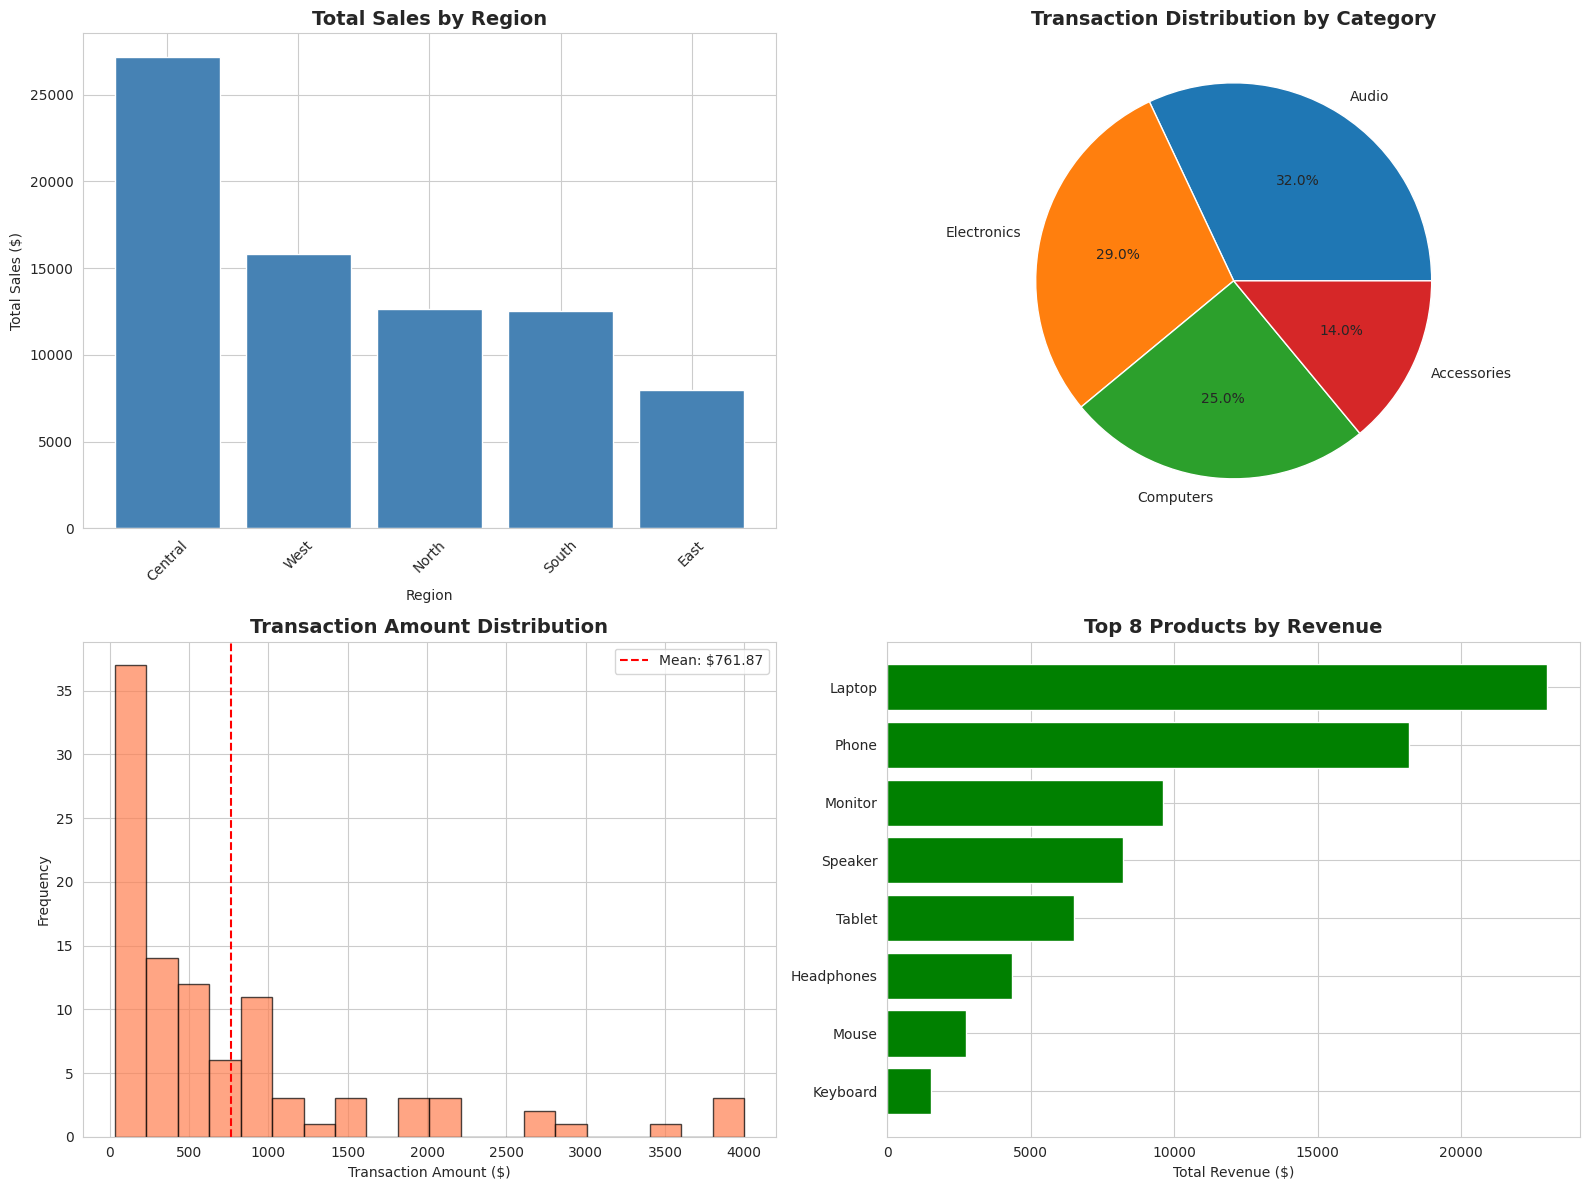

✓ Visualization saved to output/pipeline_visualization.png


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

sns.set_style('whitegrid')

# Read and analyze results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Transaction distribution by region
df = pd.DataFrame(transactions)
region_sales = df.groupby('region')['price'].sum().sort_values(ascending=False)
axes[0, 0].bar(region_sales.index, region_sales.values, color='steelblue')
axes[0, 0].set_title('Total Sales by Region', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Region')
axes[0, 0].set_ylabel('Total Sales ($)')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Category distribution
category_counts = df['category'].value_counts()
axes[0, 1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Transaction Distribution by Category', fontsize=14, fontweight='bold')

# 3. Price distribution
axes[1, 0].hist(df['price'], bins=20, edgecolor='black', color='coral', alpha=0.7)
axes[1, 0].set_title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Transaction Amount ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df['price'].mean(), color='red', linestyle='--',
                   label=f'Mean: ${df["price"].mean():.2f}')
axes[1, 0].legend()

# 4. Top products
product_revenue = df.groupby('product')['price'].sum().sort_values(ascending=True).tail(8)
axes[1, 1].barh(product_revenue.index, product_revenue.values, color='green')
axes[1, 1].set_title('Top 8 Products by Revenue', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Total Revenue ($)')

plt.tight_layout()
plt.savefig('output/pipeline_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to output/pipeline_visualization.png")

## Summary: Apache Beam Features Demonstrated

### Features Covered:

| Feature | Description | Example Use Case |
|---------|-------------|------------------|
| **ParDo** | Parallel element-wise processing | Transaction enrichment with tax calculation |
| **Map** | Transform each element | Extract customer-amount tuples |
| **Filter** | Keep elements matching condition | Filter high-value transactions |
| **Composite Transforms** | Reusable transform combinations | CustomerAnalytics, ProductAnalytics |
| **Pipeline I/O** | Read/Write data | Read JSON, write CSV and JSON files |
| **Partition** | Split into multiple streams | Segment customers by tier (Bronze/Silver/Gold) |
| **Windowing** | Time-based grouping | Fixed, Sliding, and Session windows for sales analysis |

### Key Concepts:

1. **PCollection**: Immutable distributed dataset
2. **PTransform**: Data transformation operation
3. **DoFn**: User-defined processing function
4. **Pipeline**: DAG of transformations
5. **Windowing**: Time-based data grouping
6. **Side Outputs**: Multiple outputs from single transform

### Real-World Application:

We built a complete **E-Commerce Analytics Pipeline** that:
- ✅ Processes transaction data in parallel
- ✅ Enriches data with computed fields
- ✅ Segments customers by value tier
- ✅ Analyzes sales patterns over time
- ✅ Generates targeted marketing campaigns
- ✅ Produces multiple output reports

## References:

- [Apache Beam Documentation](https://beam.apache.org/documentation/)
- [Beam Python SDK](https://beam.apache.org/documentation/sdks/python/)
- [Beam Programming Guide](https://beam.apache.org/documentation/programming-guide/)
- [Beam Examples](https://github.com/apache/beam/tree/master/sdks/python/apache_beam/examples)
- [Interactive Beam Playground](https://beam.apache.org/get-started/try-beam-playground/)

